## Importing the libraries that are necessary

In [9]:
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Conv2D,MaxPooling2D,Flatten,BatchNormalization
import talos

In [2]:
a=pd.read_csv("HAR/UCI_HAR_Dataset/train/Inertial Signals/body_acc_x_train.txt", delim_whitespace=True, header=None)
a.shape

(7352, 128)

In [3]:
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]


## Some basic facts:

<h3> We have 7352 training samples and each of them have 128 time step with 9 inputs at each time step. Hence we have to write a function to get our data into 7352 rows with each row having 128 vectors of size 9. Basically of shape (7352,128,9).</h3>

In [4]:
def load_data(subset):
    loaded_samples=[]
    for i in SIGNALS:
        
        f=pd.read_csv(f'HAR/UCI_HAR_Dataset/{subset}/Inertial Signals/{i}_{subset}.txt', delim_whitespace=True, header=None)
        loaded_samples.append(f.values)
    return np.transpose(loaded_samples,(1,2,0))

In [5]:
def load_labels(subset):
    f=pd.read_csv(f'HAR/UCI_HAR_Dataset/{subset}/y_{subset}.txt', delim_whitespace=True, header=None)
    return pd.get_dummies(f[0]).values
    

In [6]:
def load_datasets():
    x_train,x_test,y_train,y_test=load_data('train'),load_data('test'),load_labels('train'),load_labels('test')
    return x_train,x_test,y_train,y_test

## Loading the datasets:

In [7]:
x_train,x_test,y_train,y_test=load_datasets()

## LSTM Model-1

In [7]:
def recognize_human_activity(x_train, y_train, x_val, y_val, params):

    model=Sequential()
    model.add(LSTM(params['first_layer'],input_shape=(128,9),return_sequences=True))
    model.add(Dropout(params['drop_out_1']))
    model.add(LSTM(params['second_layer']))
    model.add(Dropout(params['drop_out_2']))
    model.add(Dense(params['dense'],activation="relu"))
    model.add(Dropout(params['drop_out_3']))
    model.add(Dense(6,activation="softmax"))
    model.compile(metrics=["accuracy"],optimizer="adam",loss="categorical_crossentropy")
    history=model.fit(x_train, y_train,validation_data=[x_val, y_val],batch_size=params['batch_size'],epochs=params['epochs'],callbacks=[talos.utils.live()])
    return history,model

## Hyperparameter tuning using Talos library

In [8]:
params={'first_layer':[8,16,32,64],
        'second_layer':[8,16,32,64],
       'drop_out_1':[0.3,0.5,0.7],
       'drop_out_2':[0.3,0.5,0.7],
       'drop_out_3':[0.3,0.5,0.7],
       'dense':[16,32,64,100],
       'optimizer':["adam","adagrad"],
       'batch_size':[64,128,512,1024],
       'epochs':[8,10,12,14]}


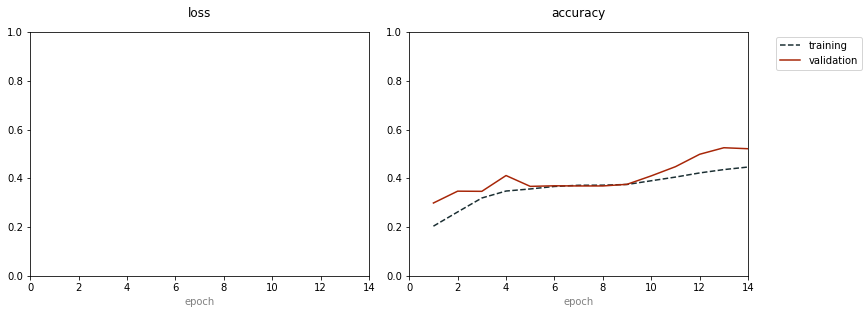





100%|██████████| 10/10 [12:09<00:00, 72.95s/it]


In [29]:
scan_object = talos.Scan(x_train,
                         y_train,
                         x_val=x_test,
                         y_val=y_test,
                         val_split=0.15 ,
                         params=params,
                         model=recognize_human_activity,
                         experiment_name='HAR',
                         round_limit=10)

In [32]:
scan_object.details


experiment_name                     HAR
random_method          uniform_mersenne
reduction_method                   None
reduction_interval                   50
reduction_window                     20
reduction_threshold                 0.2
reduction_metric                val_acc
complete_time            05/01/20/07:47
x_shape                  (7352, 128, 9)
y_shape                       (7352, 6)
dtype: object

In [33]:
analyze_object.data


,round_epochs,val_loss,val_accuracy,loss,accuracy,batch_size,dense,drop_out_1,drop_out_2,drop_out_3,epochs,first_layer,optimizer,second_layer
0,10,1.027707,0.556159,1.086811,0.528292,512,64,0.3,0.5,0.7,10,8,adam,32
1,14,0.784109,0.671530,0.653803,0.709467,512,100,0.3,0.5,0.7,14,8,adam,64
2,12,0.901588,0.621988,1.065312,0.561752,1024,32,0.5,0.7,0.5,12,64,adagrad,32
3,12,1.042917,0.635901,1.228112,0.462731,512,64,0.5,0.7,0.7,12,64,adam,8
4,8,0.843970,0.594503,0.917788,0.539309,128,32,0.5,0.3,0.3,8,16,adam,8
5,14,1.022163,0.554462,0.977557,0.586099,1024,100,0.5,0.5,0.7,14,8,adam,64
6,8,0.966695,0.582966,1.080585,0.539037,1024,64,0.5,0.7,0.5,8,64,adam,64
7,12,0.887921,0.643705,1.007619,0.584875,512,32,0.3,0.5,0.3,12,64,adagrad,8
8,8,1.060376,0.593485,1.129201,0.540125,1024,32,0.3,0.3,0.7,8,64,adagrad,64
9,14,1.230504,0.521208,1.286050,0.446137,1024,32,0.7,0.3,0.5,14,8,adam,16


## From the above table we can see that none of the models perform upto the mark.

In [44]:
def recognize_human_activity_model_2(x_train, y_train, x_val, y_val, params):

    model=Sequential()
    model.add(LSTM(params['first_layer'],input_shape=(128,9)))
    model.add(Dropout(params['drop_out_1']))
    
    model.add(Dense(6,activation="softmax"))
    model.compile(metrics=["accuracy"],optimizer="adam",loss="categorical_crossentropy")
    history=model.fit(x_train, y_train,validation_data=[x_val, y_val],batch_size=params['batch_size'],epochs=params['epochs'],callbacks=[talos.utils.live()])
    return history,model

In [45]:
params={'first_layer':[8,16,32,64],
        'second_layer':[8,16,32,64],
       'drop_out_1':[0.3,0.5,0.7],
       'drop_out_2':[0.3,0.5,0.7],
       'drop_out_3':[0.3,0.5,0.7],
       'dense':[16,32,64,100],
       'optimizer':["adam","adagrad"],
       'batch_size':[64,128,512,1024],
       'epochs':[15,20,30,40]}


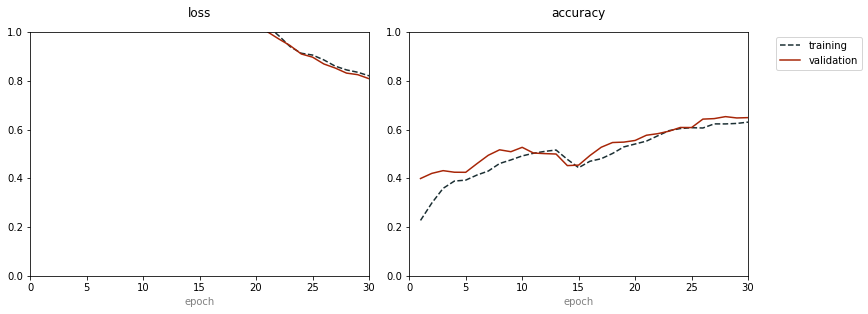









100%|██████████| 10/10 [20:21<00:00, 122.16s/it]


In [46]:
x_train,x_test,y_train,y_test=load_datasets()
scan_object = talos.Scan(x_train,
                         y_train,
                         x_val=x_test,
                         y_val=y_test,
                         params=params,
                         model=recognize_human_activity_model_2,
                         experiment_name='HAR',
                         round_limit=10)

In [47]:
analyze_object = talos.Analyze(scan_object)
analyze_object.data

,round_epochs,val_loss,val_accuracy,loss,accuracy,batch_size,dense,drop_out_1,drop_out_2,drop_out_3,epochs,first_layer,optimizer,second_layer
0,15,0.411475,0.860875,0.313300,0.913357,128,64,0.7,0.5,0.3,15,64,adagrad,16
1,15,1.408659,0.653546,0.580935,0.784684,128,16,0.7,0.5,0.5,15,32,adam,32
2,20,0.352916,0.882932,0.145438,0.943145,128,64,0.3,0.3,0.5,20,64,adam,16
3,40,0.435675,0.865287,0.243220,0.926959,1024,32,0.5,0.5,0.7,40,64,adam,16
4,30,0.784642,0.632508,0.760306,0.649075,1024,100,0.3,0.5,0.7,30,16,adam,64
5,15,0.957987,0.599932,0.583941,0.769995,512,100,0.7,0.7,0.5,15,64,adam,32
6,30,0.358834,0.888700,0.215881,0.930631,128,16,0.3,0.3,0.7,30,32,adam,16
7,15,0.656953,0.759077,0.449310,0.840860,128,32,0.3,0.3,0.5,15,64,adam,64
8,20,0.533722,0.821853,0.487310,0.830250,128,100,0.7,0.5,0.5,20,64,adam,16
9,30,0.808433,0.648795,0.820271,0.630305,1024,100,0.7,0.7,0.5,30,32,adagrad,32


## Even in the above we can see that none of the models give the desired accuracy.

## Hence we are going to try CNN based models

## Reshaping the data so that it can be fed as input to CNN:

In [8]:
x_train,x_test,y_train,y_test=load_datasets()
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2],1)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2],1)

## CNN MODEL-1

In [45]:
def model_cnn(x_train,y_train,x_val,y_val,params):
    model=Sequential()
    model.add(Conv2D(filters=params['filters'],kernel_size=params['kernel_size'],kernel_regularizer="l2",activation="relu",kernel_initializer=params['initializer']))
    model.add(Conv2D(filters=params['filters'],kernel_size=params['kernel_size'],kernel_regularizer="l2",activation="relu",kernel_initializer=params['initializer']))
    model.add(MaxPooling2D(pool_size=params["max_pool"], strides=None, padding='same', data_format='channels_last'))
    model.add(Flatten())
    model.add(Dense(6,activation="softmax"))
    model.compile(metrics=["accuracy"],optimizer="adam",loss="categorical_crossentropy")
    history=model.fit(x_train, y_train,validation_data=[x_val, y_val],batch_size=params['batch_size'],epochs=params['epochs'],callbacks=[talos.utils.live()])
    return history,model

In [46]:
params={'filters':[16,32,64,96],
       'kernel_size':[(2,2),(3,3),(5,5)],
       'initializer':['he_normal','glorot_normal'],
       'max_pool':[(2,2),(3,3),(5,5)],
       'batch_size':[64,128,512,1024],
       'epochs':[15,20,30,40,50,60]
       }

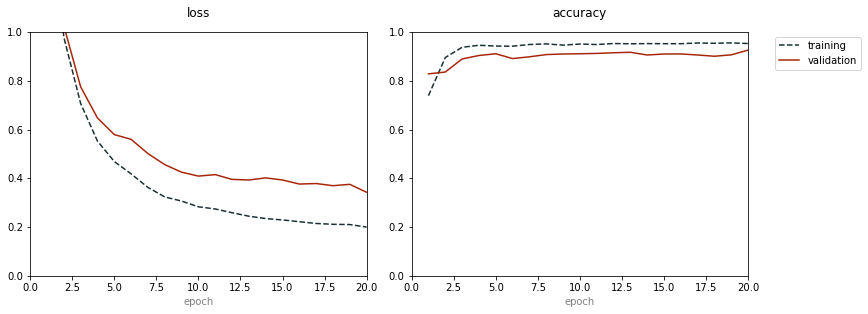






100%|██████████| 10/10 [30:00<00:00, 180.09s/it]


In [47]:
scan_object_cnn = talos.Scan(x_train,
                         y_train,
                         x_val=x_test,
                         y_val=y_test,
                         params=params,
                         model=model_cnn,
                         experiment_name='HAR',
                         round_limit=10)

In [34]:
## Above we see the accuracy going up with epochs in the learning curve for the choosen model

In [48]:
analyze_object = talos.Analyze(scan_object_cnn)
analyze_object.data

,round_epochs,val_loss,val_accuracy,loss,accuracy,batch_size,epochs,filters,initializer,kernel_size,max_pool
0,30,0.490238,0.890058,0.291800,0.958107,128,30,32,he_normal,"(2, 2)","(3, 3)"
1,40,0.453825,0.861893,0.196400,0.961099,128,40,16,glorot_normal,"(2, 2)","(2, 2)"
2,30,0.410041,0.896166,0.229350,0.952258,512,30,64,glorot_normal,"(3, 3)","(3, 3)"
3,60,0.491944,0.898202,0.364003,0.953482,1024,60,64,he_normal,"(5, 5)","(5, 5)"
4,15,0.718064,0.785545,0.476414,0.886289,1024,15,32,glorot_normal,"(2, 2)","(2, 2)"
5,30,0.621700,0.874109,0.440351,0.948857,512,30,96,he_normal,"(5, 5)","(3, 3)"
6,60,0.351684,0.910078,0.125883,0.961779,64,60,32,he_normal,"(5, 5)","(2, 2)"
7,15,0.903348,0.890058,0.776603,0.952122,512,15,64,he_normal,"(5, 5)","(3, 3)"
8,20,0.384136,0.894808,0.232845,0.951442,128,20,96,he_normal,"(5, 5)","(2, 2)"
9,20,0.342566,0.925687,0.199633,0.952802,64,20,32,he_normal,"(5, 5)","(5, 5)"


## We observe above that the last model which we trained with 20 epochs have a validation accuracy of 92.5% and a train accuracy of 95.2%

## In this model we have used CNN rather than a LSTM to make it work. This seems to have achieved the objerctive of the assignment.

## Conclusions:

In [33]:
from prettytable import PrettyTable

In [37]:
x=PrettyTable(["Model","Description of the Model","Train Accuracy","Test Accuracy"])
x.add_row(["LSTM Model-1\n\n","LSTM+dropout+LSTM+dropout+Dense+dropout+softmax+adagrad\n\n","70%\n\n","67%\n\n"])
x.add_row(["LSTM Model-2\n\n","LSTM+dropout+softmax+adam\n\n","94%\n\n","88%\n\n"])
x.add_row(["CNN MODEL-1\n\n","CONV+CONV+MAXPOOL+FLATTEN+DENSE+ADAM\n\n","95%\n\n","92%\n\n"])
print(x)

+--------------+---------------------------------------------------------+----------------+---------------+
|    Model     |                 Description of the Model                | Train Accuracy | Test Accuracy |
+--------------+---------------------------------------------------------+----------------+---------------+
| LSTM Model-1 | LSTM+dropout+LSTM+dropout+Dense+dropout+softmax+adagrad |      70%       |      67%      |
|              |                                                         |                |               |
|              |                                                         |                |               |
| LSTM Model-2 |                LSTM+dropout+softmax+adam                |      94%       |      88%      |
|              |                                                         |                |               |
|              |                                                         |                |               |
| CNN MODEL-1  |           C

<b> We observe that CNN based model did better than the LSTM models though the LSTM Models were expected to do better.</b>